In [67]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils, prf_utils
from feature_extraction import sketch_token_features
from model_fitting import initialize_fitting as initialize_fitting
import matplotlib.pyplot as plt

fpX = np.float32
device = 'cpu:0'

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-19-2021_1224_16/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recs', 'voxel_recs', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])
subject = 1
volume_space = 1
fitting_type = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1


In [3]:
fitting_type='sketch_tokens';
subject=1; volume_space = True; up_to_sess = 1;
sample_batch_size = 50; voxel_batch_size = 100; \

zscore_features = True; zscore_in_groups = False; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; use_precomputed_prfs = False; do_val = True; do_stack=True; \
do_varpart = True; do_roi_recons=False; do_voxel_recons=False; date_str = 0; \

shuff_rnd_seed = 301119; 
debug = True;

use_pca_st_feats = False; use_lda_st_feats = False; lda_discrim_type = None; \
min_pct_var = 99; max_pc_to_retain = 400; \


In [17]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = False, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)




Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [19]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


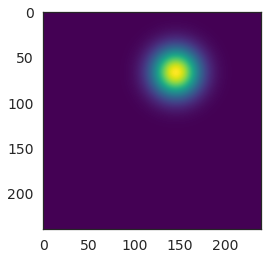

In [114]:
plt.figure();
plt.imshow(prf_2d)

9656
V1
[0.33       0.33       0.07722791]


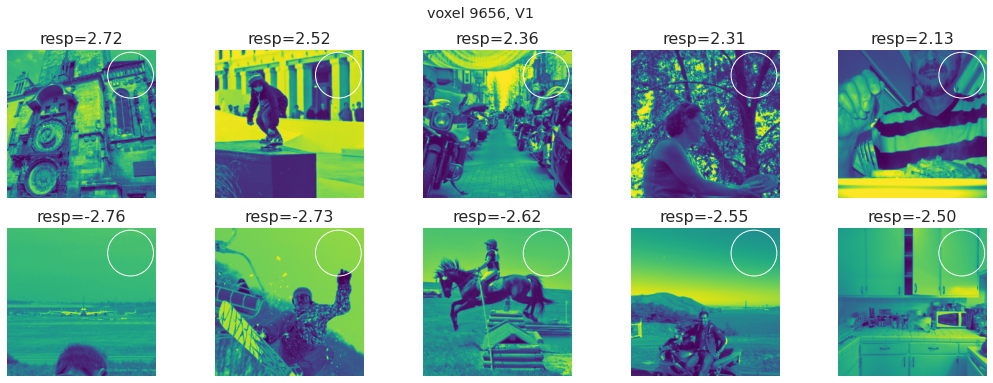

In [123]:
this_roi = np.where(retlabs==0)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[1]
vind = this_roi[vind]
print(vind)
name = np.array(ret_names)[int(retlabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

13641
hV4
[-0.11        0.33        0.07722791]


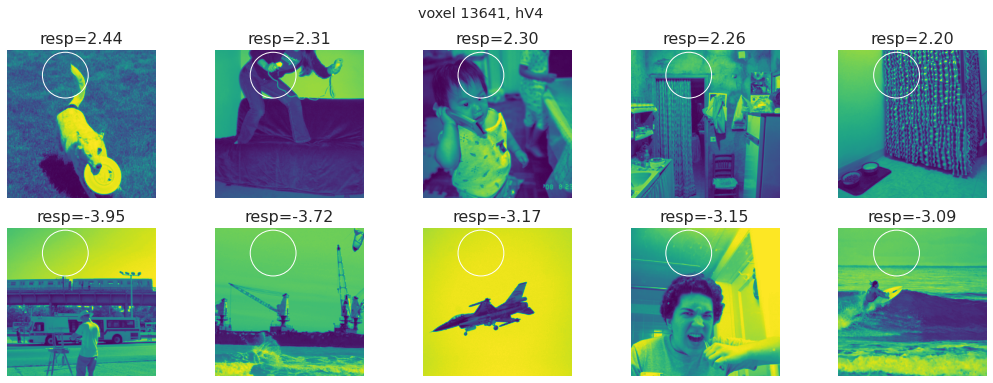

In [125]:
this_roi = np.where(retlabs==3)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[0]
vind = this_roi[vind]
print(vind)
name = np.array(ret_names)[int(retlabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

482
EBA
[0.         0.         0.28787428]


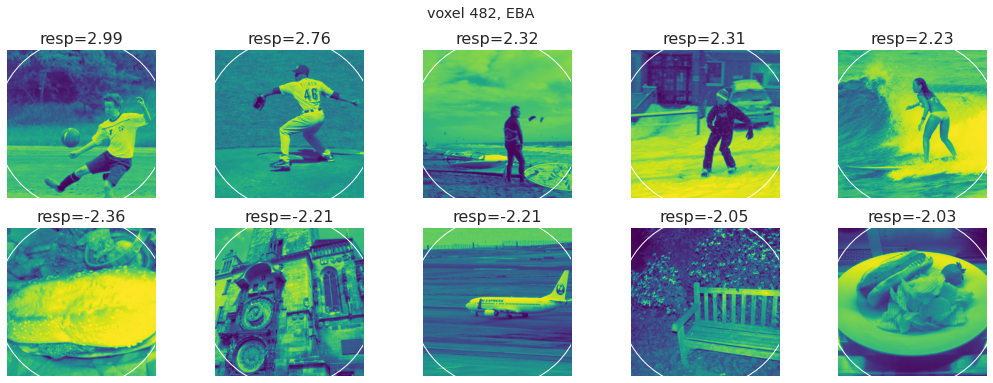

In [127]:
this_roi = np.where(bodylabs==0)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[1]
vind = this_roi[vind]
print(vind)
name = np.array(body_names)[int(bodylabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

1625
FFA-1
[0.         0.         0.28787428]


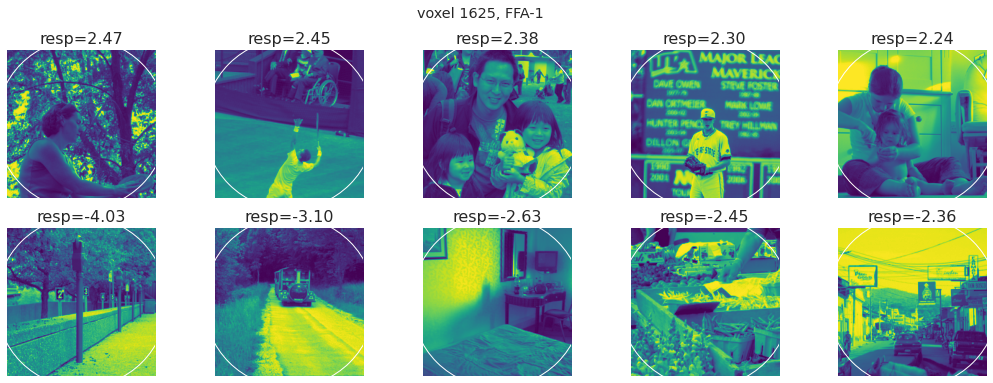

In [110]:
this_roi = np.where(facelabs==1)[0]
vind = np.argmax(out['val_cc'][this_roi,0])
vind = this_roi[vind]
print(vind)
name = np.array(face_names)[int(facelabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

16410
FFA-1
[0.         0.         0.28787428]


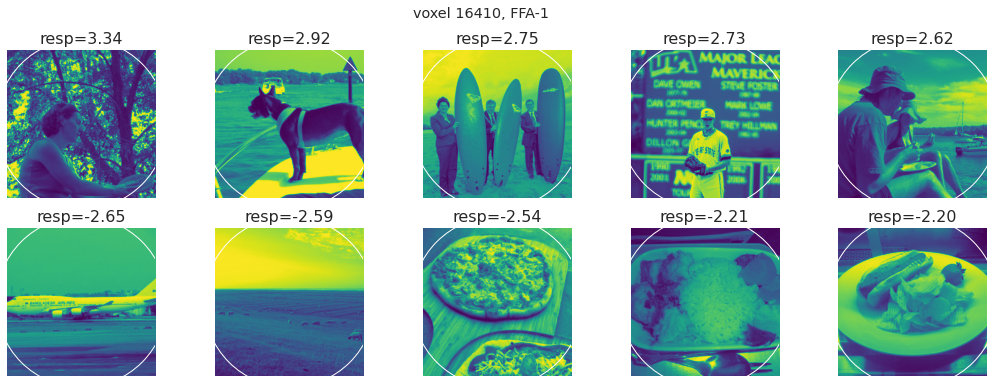

In [112]:
this_roi = np.where(facelabs==1)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[1]
vind = this_roi[vind]
print(vind)
name = np.array(face_names)[int(facelabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

2587
FFA-1
[0.         0.         0.28787428]


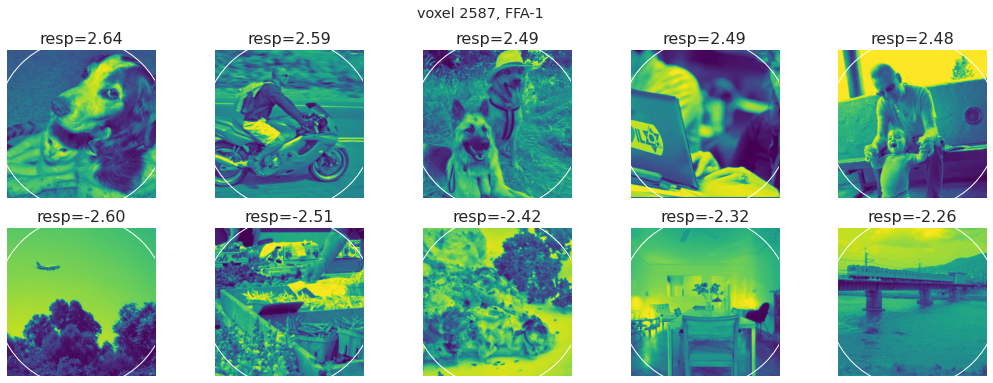

In [118]:
this_roi = np.where(facelabs==1)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[2]
vind = this_roi[vind]
print(vind)
name = np.array(face_names)[int(facelabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)

1624
FFA-1
[0.         0.         0.28787428]


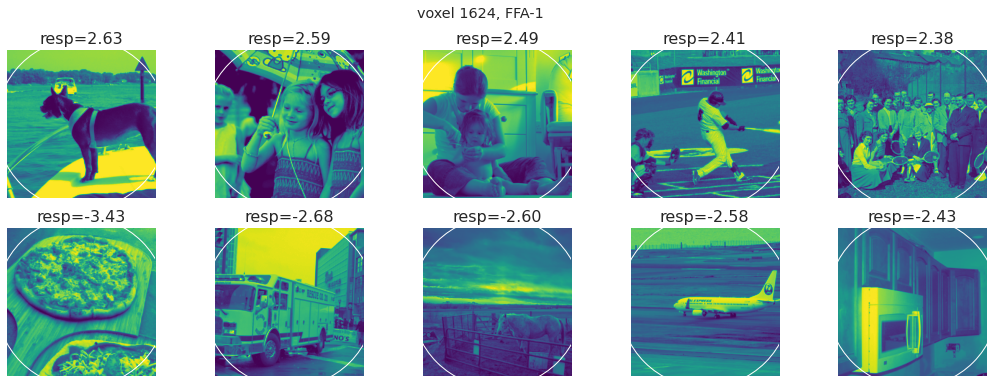

In [119]:
this_roi = np.where(facelabs==1)[0]
vind = np.flip(np.argsort(out['val_cc'][this_roi,0]))[3]
vind = this_roi[vind]
print(vind)
name = np.array(face_names)[int(facelabs[vind])] 
print(name)

trn_resp = trn_voxel_data[:,vind]
top_n = 5
top_trials = np.flip(np.argsort(trn_resp))[0:top_n]
bottom_trials = np.argsort(trn_resp)[0:top_n]
top_resp = trn_resp[top_trials]
bottom_resp = trn_resp[bottom_trials]
top_images = trn_stim_data[top_trials,0,:,:]
bottom_images = trn_stim_data[bottom_trials,0,:,:]

prf_model_index = out['best_params'][5][vind,0]
prf_params = out['models'][prf_model_index]
x,y,sigma = prf_params
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=240)
# center goes [row ind, col ind]
n_pix = 240
# invert y direction here for imshow
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('resp=%.2f'%bottom_resp[ii])
plt.suptitle('voxel %d, %s'%(vind, name))
print(prf_params)